## KING COUNTY HOUSE PRICE PREDICTION

## Final Project Submission

Please fill out: GROUP 5
* Student name: Prudence Coredo, Titus Mutuku, Gloria Nyongesa, Candy  Gudda, Eric Lintari, Sadi Kiri
* Student pace:full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


# Overview
This project investigates the factors affecting prices of houses in King County, Washington.

# Business Understanding
To identify how house prices are affected by various factors and to provide a guide on how to best identify properties that bear a high resell value for to maximize on profit margins.

# Background 
King County has witnessed a vibrant real estate market.The housing market in this county is competitive, and homeowners looking to buy or sell properties frequently seek guidance from local real estate agencies. One common concern among homeowners is the potential value added by home renovations. This project aims to provide data-driven insights into this issue, helping homeowners make informed decisions on their properties. The King County House Sales dataset serves as a valuable resource for this analysis.

## Data Exploration/Understanding
- This dataset contains house sales prices for King County. It includes homes sold between May 2014 and May 2015.
- The dependent Variable: Sales Price / Selling Price
- The predictors: the sale date, renovation year, number of bedrooms and bathrooms, number of floors, the square footage of the   houses (both living and lot), and available view of waterfront. Also, the dataset contains the grade and condition of each       house.
- Datatypes: All are integers or Float except the  date and sqft_basement (object).
- Distribution of our data:
   - continuous: sqft_living, sqft_lot, sqft_above, sqft_basement (after adjustment), gap year between sold and built/renovated
   - discrete: bedrooms, bathrooms, grade, floors, condition
   - categorical: waterfront
- Our datasets contain 21,597 items of house sale information
- We will eliminate the information such as house ID, zipcode, latitude and longitude, and whether the house has been viewed or not.

### Importing Libraries

#### Importing the relevant modules and the dataset

In [48]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
plt.style.use('seaborn')

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

#### Loading the dataset using pandas

In [49]:
# Loading the data
df = pd.read_csv('data/kc_house_data.csv')
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,8 Good,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,8 Good,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,7 Average,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,...,8 Good,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


The dataset contains 21597 rows and 21 columns. Each row of the dataset contains information about one house.

Our objective is to find a way to estimate the value in the "price" column using the values in the other columns. By achieving this using this set of data, then we should able to estimate prices of other houses too, simply by asking for information like bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade','sqft_above', 'sqft_basement' etc

### Data Understanding

Obtaing the statistical summary of our dataset such as mean, standard deviation, median etc

In [50]:
#Obtaining the statistical summary of the data set
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,21597.0,4.580474e+09,2.876736e+09,1.000102e+06,2.123049e+09,3.904930e+09,7.308900e+09,9.900000e+09
price,21597.0,5.402966e+05,3.673681e+05,7.800000e+04,3.220000e+05,4.500000e+05,6.450000e+05,7.700000e+06
bedrooms,21597.0,3.373200e+00,9.262989e-01,1.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.300000e+01
bathrooms,21597.0,2.115826e+00,7.689843e-01,5.000000e-01,1.750000e+00,2.250000e+00,2.500000e+00,8.000000e+00
sqft_living,21597.0,2.080322e+03,9.181061e+02,3.700000e+02,1.430000e+03,1.910000e+03,2.550000e+03,1.354000e+04
sqft_lot,21597.0,1.509941e+04,4.141264e+04,5.200000e+02,5.040000e+03,7.618000e+03,1.068500e+04,1.651359e+06
floors,21597.0,1.494096e+00,5.396828e-01,1.000000e+00,1.000000e+00,1.500000e+00,2.000000e+00,3.500000e+00
sqft_above,21597.0,1.788597e+03,8.277598e+02,3.700000e+02,1.190000e+03,1.560000e+03,2.210000e+03,9.410000e+03
yr_built,21597.0,1.971000e+03,2.937523e+01,1.900000e+03,1.951000e+03,1.975000e+03,1.997000e+03,2.015000e+03
yr_renovated,17755.0,8.363678e+01,3.999464e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.015000e+03


Checking for more information on our data

In [51]:
# Get more infomation on the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

Checking for any missing values in our data

In [52]:
#Checking for missing values
df.isnull().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

#### Data Cleaning / Preparation

Data preparation is the process of cleaning and transforming raw data prior to processing and analysis

Dropping columns that will not be usefull in our analysis

In [53]:
df_cleaned = df.drop(['id','date','view','sqft_living15','sqft_lot15','sqft_basement',"sqft_above",'yr_renovated'], axis = 1)
df_cleaned

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,zipcode,lat,long
0,221900.0,3,1.00,1180,5650,1.0,NaN,Average,7 Average,1955,98178,47.5112,-122.257
1,538000.0,3,2.25,2570,7242,2.0,NO,Average,7 Average,1951,98125,47.7210,-122.319
2,180000.0,2,1.00,770,10000,1.0,NO,Average,6 Low Average,1933,98028,47.7379,-122.233
3,604000.0,4,3.00,1960,5000,1.0,NO,Very Good,7 Average,1965,98136,47.5208,-122.393
4,510000.0,3,2.00,1680,8080,1.0,NO,Average,8 Good,1987,98074,47.6168,-122.045
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,NO,Average,8 Good,2009,98103,47.6993,-122.346
21593,400000.0,4,2.50,2310,5813,2.0,NO,Average,8 Good,2014,98146,47.5107,-122.362
21594,402101.0,2,0.75,1020,1350,2.0,NO,Average,7 Average,2009,98144,47.5944,-122.299
21595,400000.0,3,2.50,1600,2388,2.0,NaN,Average,8 Good,2004,98027,47.5345,-122.069


In [54]:
#Checking information of the data after dropping the columns
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21597 non-null  float64
 1   bedrooms     21597 non-null  int64  
 2   bathrooms    21597 non-null  float64
 3   sqft_living  21597 non-null  int64  
 4   sqft_lot     21597 non-null  int64  
 5   floors       21597 non-null  float64
 6   waterfront   19221 non-null  object 
 7   condition    21597 non-null  object 
 8   grade        21597 non-null  object 
 9   yr_built     21597 non-null  int64  
 10  zipcode      21597 non-null  int64  
 11  lat          21597 non-null  float64
 12  long         21597 non-null  float64
dtypes: float64(5), int64(5), object(3)
memory usage: 2.1+ MB


Checking to see if there are any missing values in our data

In [55]:
#Checking for null values in cleaned dataset
df_cleaned.isnull().sum()

price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront     2376
condition         0
grade             0
yr_built          0
zipcode           0
lat               0
long              0
dtype: int64

From this we can see that the waterfront columns has missing values and therefore we will drop them

In [56]:
# Removing null values for the dataset
df_cleaned = df_cleaned.dropna()
df_cleaned

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,zipcode,lat,long
1,538000.0,3,2.25,2570,7242,2.0,NO,Average,7 Average,1951,98125,47.7210,-122.319
2,180000.0,2,1.00,770,10000,1.0,NO,Average,6 Low Average,1933,98028,47.7379,-122.233
3,604000.0,4,3.00,1960,5000,1.0,NO,Very Good,7 Average,1965,98136,47.5208,-122.393
4,510000.0,3,2.00,1680,8080,1.0,NO,Average,8 Good,1987,98074,47.6168,-122.045
5,1230000.0,4,4.50,5420,101930,1.0,NO,Average,11 Excellent,2001,98053,47.6561,-122.005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,475000.0,3,2.50,1310,1294,2.0,NO,Average,8 Good,2008,98116,47.5773,-122.409
21592,360000.0,3,2.50,1530,1131,3.0,NO,Average,8 Good,2009,98103,47.6993,-122.346
21593,400000.0,4,2.50,2310,5813,2.0,NO,Average,8 Good,2014,98146,47.5107,-122.362
21594,402101.0,2,0.75,1020,1350,2.0,NO,Average,7 Average,2009,98144,47.5944,-122.299


In [57]:
#Checking for duplicates
df_cleaned.duplicated()

1        False
2        False
3        False
4        False
5        False
         ...  
21591    False
21592    False
21593    False
21594    False
21596    False
Length: 19221, dtype: bool

In [58]:
#Checking the frequency of unique values in each column 
for val in df_cleaned:
   print(df_cleaned[val].value_counts())
   print()

price
450000.0    153
350000.0    147
550000.0    144
500000.0    142
425000.0    135
           ... 
443750.0      1
204750.0      1
406550.0      1
278800.0      1
402101.0      1
Name: count, Length: 3391, dtype: int64

bedrooms
3     8721
4     6149
2     2451
5     1441
6      227
1      175
7       35
8       11
9        6
10       3
11       1
33       1
Name: count, dtype: int64

bathrooms
2.50    4839
1.00    3411
1.75    2725
2.25    1788
2.00    1722
1.50    1283
2.75    1038
3.00     662
3.50     656
3.25     521
3.75     136
4.00     121
4.50      91
4.25      73
0.75      65
4.75      22
5.00      17
5.25      11
5.50      10
1.25       8
6.00       6
0.50       4
5.75       3
6.75       2
8.00       2
6.25       2
7.50       1
7.75       1
6.50       1
Name: count, dtype: int64

sqft_living
1300    125
1440    121
1400    120
1820    118
1660    113
       ... 
2497      1
2331      1
1899      1
3316      1
1425      1
Name: count, Length: 992, dtype: int64

sqft_lot
50

In [59]:
# Spliting the grade column to a new column which only has the grade value in numbers.

df_cleaned.loc[:, 'grade'] = df_cleaned['grade'].str.split(' ').str[0]

In [60]:
#Changing the data type of grade from str to int
df_cleaned.loc[:, 'grade'] = df_cleaned['grade'].astype(np.int64)

In [61]:
# Changing  catergorical data in the condition column to numeric

df_cleaned.loc[:,'condition'] = df_cleaned['condition'].map({'Poor':1, 'Fair':2, 'Average':3, 'Good':4, 'Very Good':5})
df_cleaned

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,zipcode,lat,long
1,538000.0,3,2.25,2570,7242,2.0,NO,3,7,1951,98125,47.7210,-122.319
2,180000.0,2,1.00,770,10000,1.0,NO,3,6,1933,98028,47.7379,-122.233
3,604000.0,4,3.00,1960,5000,1.0,NO,5,7,1965,98136,47.5208,-122.393
4,510000.0,3,2.00,1680,8080,1.0,NO,3,8,1987,98074,47.6168,-122.045
5,1230000.0,4,4.50,5420,101930,1.0,NO,3,11,2001,98053,47.6561,-122.005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,475000.0,3,2.50,1310,1294,2.0,NO,3,8,2008,98116,47.5773,-122.409
21592,360000.0,3,2.50,1530,1131,3.0,NO,3,8,2009,98103,47.6993,-122.346
21593,400000.0,4,2.50,2310,5813,2.0,NO,3,8,2014,98146,47.5107,-122.362
21594,402101.0,2,0.75,1020,1350,2.0,NO,3,7,2009,98144,47.5944,-122.299


In [62]:
# From this we can tell the condition of most houses is average.
df_cleaned['condition'].value_counts()

condition
3    12474
4     5058
5     1512
2      152
1       25
Name: count, dtype: int64

In [63]:
df_cleaned['waterfront'] = df['waterfront'].replace({'YES': 1, 'NO':0})
df_cleaned.loc[:, 'waterfront'] = df_cleaned['waterfront'].astype(np.int64)

This will now make it easier when carrying out statistical measurements.


In [64]:
#Checking data information
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19221 entries, 1 to 21596
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        19221 non-null  float64
 1   bedrooms     19221 non-null  int64  
 2   bathrooms    19221 non-null  float64
 3   sqft_living  19221 non-null  int64  
 4   sqft_lot     19221 non-null  int64  
 5   floors       19221 non-null  float64
 6   waterfront   19221 non-null  float64
 7   condition    19221 non-null  object 
 8   grade        19221 non-null  object 
 9   yr_built     19221 non-null  int64  
 10  zipcode      19221 non-null  int64  
 11  lat          19221 non-null  float64
 12  long         19221 non-null  float64
dtypes: float64(6), int64(5), object(2)
memory usage: 2.1+ MB


Our data is now cleaned and ready to be analysed

## EDA

Exploratory Data Analysis involves exploration and assessment the dataset to uncover its main characteristics, using various tools and methods such as visualizations and statistics.

Data Distribution

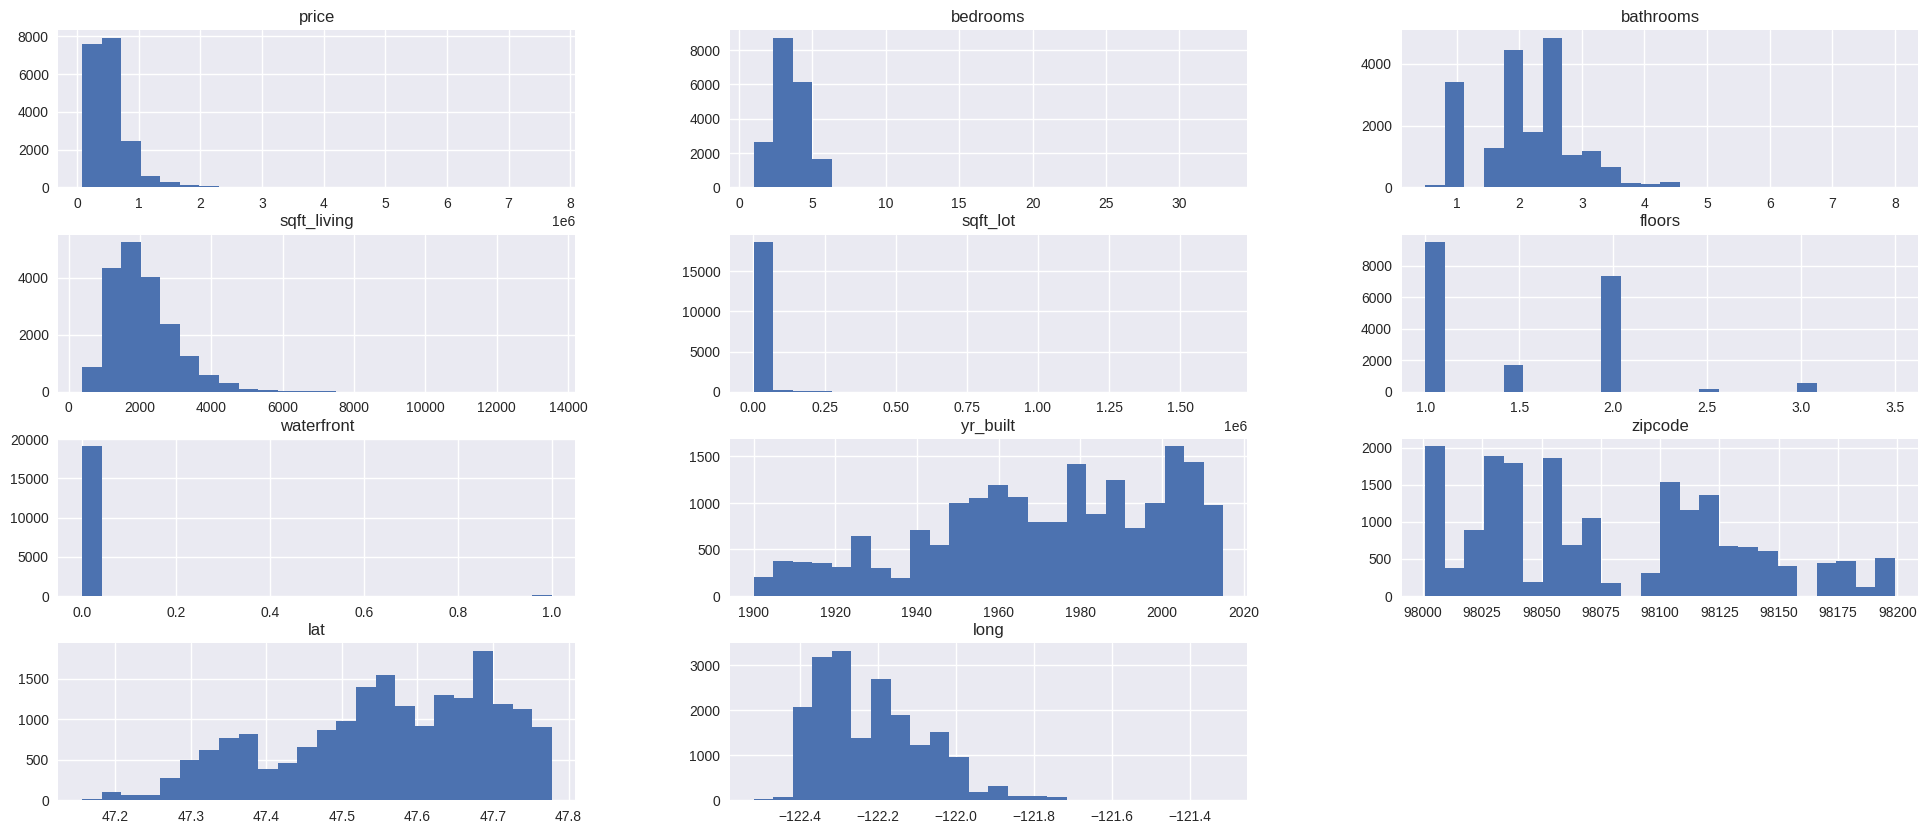

In [65]:
#plotting histograms to visualize patterns in the data
df_cleaned.hist(figsize = (24,10), bins= 24)
plt.show()

## The relationship between Target and predictor variable

To examine and visualize the relationship between variables

In [66]:
#Checking the statistical summary of price column
df_cleaned['price'].describe()

count    1.922100e+04
mean     5.416398e+05
std      3.722478e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.440000e+05
max      7.700000e+06
Name: price, dtype: float64

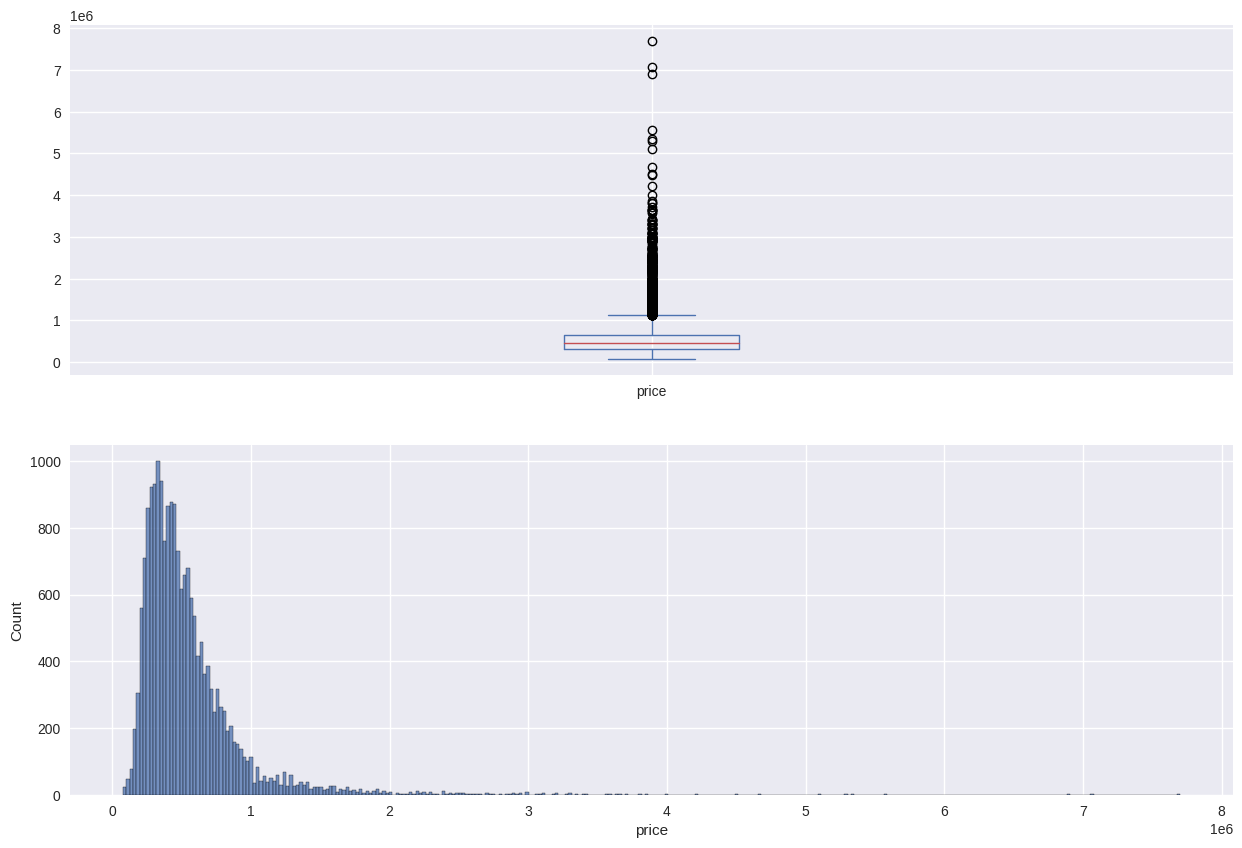

In [67]:
# creating two plots to visualize the distribution of a 'price' column in the cleaned Dataframe
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax1 = df_cleaned['price'].plot.box()
ax2 = fig.add_subplot(212)
ax2 = sns.histplot(data=df_cleaned, x='price')

In [68]:
# Calculate the mean, median, and mode and the max_price
# Calculate the mean
mean_price = df_cleaned['price'].mean()

# Calculate the median
median_price = df_cleaned['price'].median()

# Calculate the mode
mode_price = df_cleaned['price'].mode()
# Calculate Maximum price 
max_price = df_cleaned['price'].max()

print(f"The maximum price is: {max_price}")
print(f"The mean price is: {mean_price}")
print(f"The median price is: {median_price}")
print(f"The mode price is: {mode_price}")

The maximum price is: 7700000.0
The mean price is: 541639.8338275844
The median price is: 450000.0
The mode price is: 0    450000.0
Name: price, dtype: float64


**Comments**
- Observations: The Price data is heavily skewed because it is apparent there are many outliers. The average price of a house in King County is 540k while the median price is 450k which can be associated with affordability and the Middle class members of the society. the highest priced house/home is at $7.7 Millionwhich is significaqntly higher compared to the average price
* Action: Remove the Outliers in the price field/column because most clients of the expected clients are middle class hence the target clients for all investors. In order to reduce the skewness, we will remove the houses with prices over USD 1M (keeping 93% of data).

In [69]:
#Remove the outliers of prices to avoid skewness
df_filtered = df_cleaned[df_cleaned['price'] <= 1000000].copy()
df_filtered

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,zipcode,lat,long
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,1951,98125,47.7210,-122.319
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,1933,98028,47.7379,-122.233
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1965,98136,47.5208,-122.393
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1987,98074,47.6168,-122.045
6,257500.0,3,2.25,1715,6819,2.0,0.0,3,7,1995,98003,47.3097,-122.327
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,475000.0,3,2.50,1310,1294,2.0,0.0,3,8,2008,98116,47.5773,-122.409
21592,360000.0,3,2.50,1530,1131,3.0,0.0,3,8,2009,98103,47.6993,-122.346
21593,400000.0,4,2.50,2310,5813,2.0,0.0,3,8,2014,98146,47.5107,-122.362
21594,402101.0,2,0.75,1020,1350,2.0,0.0,3,7,2009,98144,47.5944,-122.299


Removed records whose price was above 1 million dollars

### Analyzing Number of Bathrooms

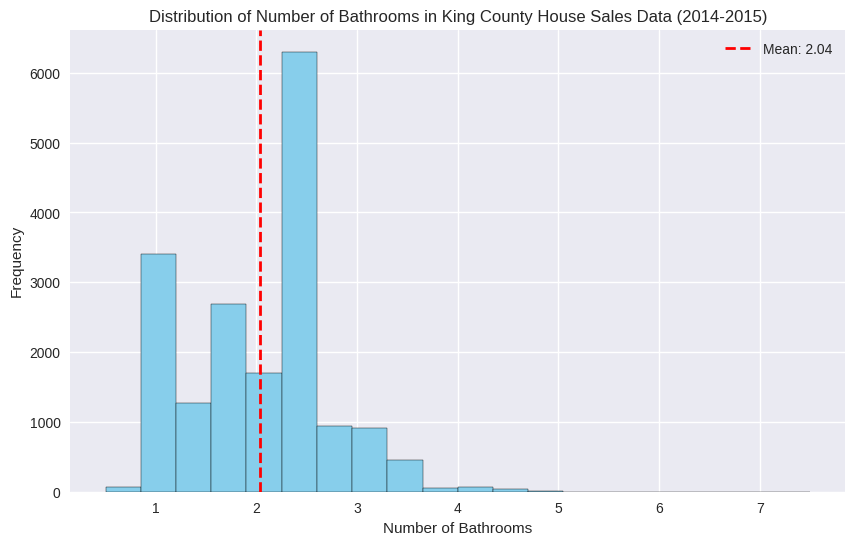

In [70]:
bathrooms= df_filtered['bathrooms']

#mean
mean_bathrooms =  bathrooms.mean()
# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(bathrooms, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Bathrooms in King County House Sales Data (2014-2015)')
plt.grid(True)

# Add a vertical line at the mean
plt.axvline(mean_bathrooms, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_bathrooms:.2f}')

# Show the histogram
plt.legend()
plt.show()

Based on this values, the peak(mode) of the data is around 2.5. Most houses have 2-3 bathrooms.
This distribution does not have outliers.
Based on the mean and the mode, the estimate gives a point for where the center of the data is located.

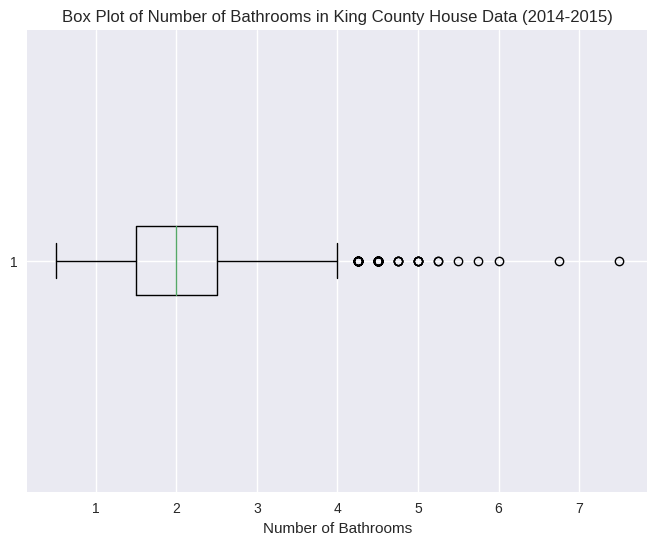

In [71]:
plt.figure(figsize=(8, 6))
plt.boxplot(bathrooms,vert= False)  # vert=False for a horizontal box plot
plt.xlabel('Number of Bathrooms')
plt.title('Box Plot of Number of Bathrooms in King County House Data (2014-2015)')
plt.grid(True)
plt.show()

The data indicates potential presence of outliers in the data that probably have affected the mean

In [72]:
# Calculate the first quartile (Q1) and third quartile (Q3)
Q1 = bathrooms.quantile(0.25)
Q3 = bathrooms.quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers with NaN in the original "bathrooms" column
df_filtered['bathrooms'][~((bathrooms >= lower_bound) & (bathrooms <= upper_bound))] = None

In [73]:
mean_bathrooms = df_filtered['bathrooms'].mean()
df_filtered['bathrooms'].fillna(mean_bathrooms, inplace=True)

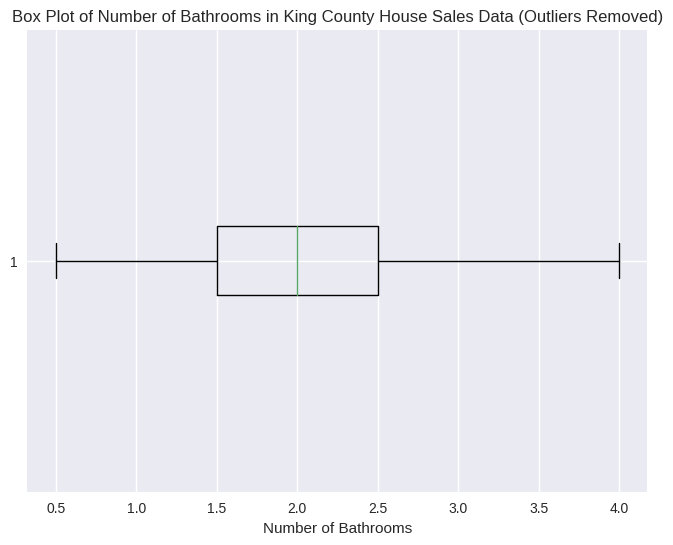

In [74]:
# confirming that outliers have been removed
# Create a box plot for the "bathrooms" column in the updated data
plt.figure(figsize=(8, 6))
plt.boxplot(df_filtered['bathrooms'][df_filtered['bathrooms'].notna()], vert=False)  # vert=False for a horizontal box plot
plt.xlabel('Number of Bathrooms')
plt.title('Box Plot of Number of Bathrooms in King County House Sales Data (Outliers Removed)')
plt.grid(True)
plt.show()

Reasonable mean of 2 bathrooms per house!

### Analyzing Condition

#### How does the feature 'Condition' impact house price?

For this question, we will be exploring the relationship between the condition rating and house prices. We aim to determine whether houses with different condition rating exhibit varying price trends. This investigation will provide valuable insights into the impacts of condition on the housing market, potentially influencing pricing strategies and buyer preferences.

In [75]:
# We use the value_counts method to visualize the frequencies of the ratings
# We see that despite dropping the records with outliers in the price column, the distribution of ratings has not significantly changed
df = df_filtered
df['condition'].value_counts().to_frame()

,count
condition,
3,11631
4,4763
5,1344
2,150
1,24


Next, we use a histogram to further enhance our visualization of how these ratings are distributed.

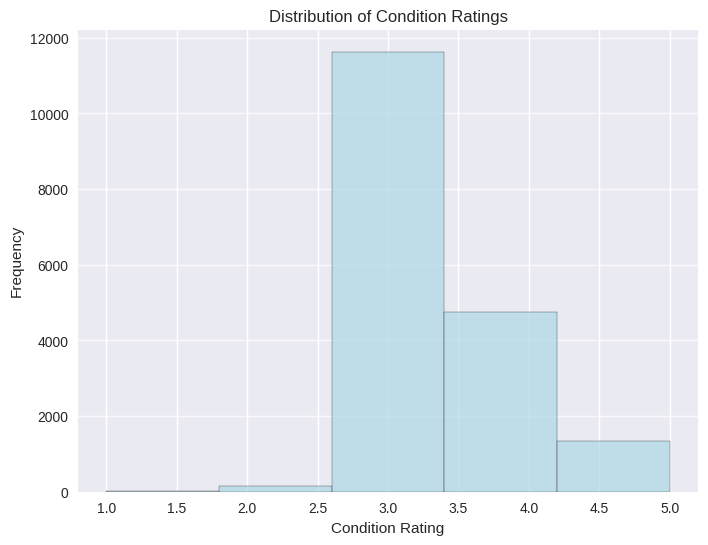

In [76]:
# Plot a histogram to show the distribution of the condition column
plt.figure(figsize=(8, 6)) 
num_bins = 5
plt.hist(df['condition'], bins=num_bins, color='lightblue', alpha=0.7, edgecolor='black')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Condition Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Condition Ratings')

plt.show();

Since the feature condition represents quality ratings, our histogram visualization reveals key insights about the quality distribution within the dataset. 

We observe that a significant portion of the houses are rated as "average". This suggests that "average" quality is the prevailing condition of most houses in our dataset. 

It is also important to note that there are house with ratings above and below average implying that we have a variability in quality.

### Correlation Matrix

Using a heatmap to find out the correlation between the variables of this data set

In [77]:
# Finding out the correlation between the features
df_filtered.corr()['price']

price          1.000000
bedrooms       0.288130
bathrooms      0.429370
sqft_living    0.604018
sqft_lot       0.096277
floors         0.272705
waterfront     0.054877
condition      0.032246
grade          0.617624
yr_built       0.060289
zipcode       -0.014896
lat            0.443004
long           0.080438
Name: price, dtype: float64

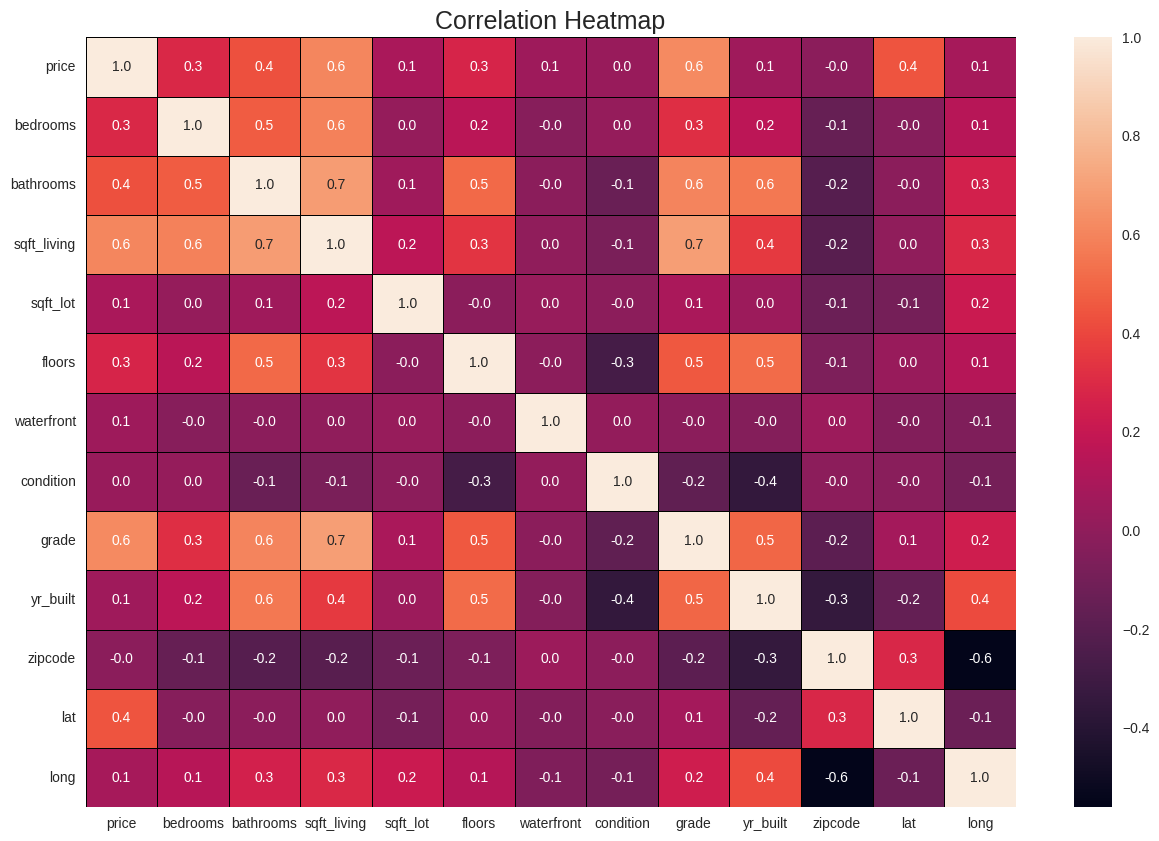

In [78]:
# Plotting a correlation heatmap using seaborn. Border the squares with black color, show the correlation index and round it up.
plt.figure(figsize=(15, 10))  # Set the figure size
sns.heatmap(df_filtered.corr(), annot=True, linewidths=0.5, linecolor='black', fmt='1.1f')

# Give a title to the map and display it.
plt.title('Correlation Heatmap', size=18)
plt.show()

## MODELLING

Regression Analysis:

We will focus specifically on a subset of the overall dataset to perform our regression analysis. Regression analysis will allow us to quantify the extent to which these features affect house prices and provide a predictive model for pricing. 

The features considered are those that are highly correlated with our target price 'price' as seen from our correlation matrix and correlation heatmap.
They include: sqft_living 
              bathrooms
              grade

In [79]:
df_subset = df[['sqft_living', 'bathrooms', 'grade', 'price']]
df_subset

,sqft_living,bathrooms,grade,price
1,2570,2.25,7,538000.0
2,770,1.00,6,180000.0
3,1960,3.00,7,604000.0
4,1680,2.00,8,510000.0
6,1715,2.25,7,257500.0
...,...,...,...,...
21591,1310,2.50,8,475000.0
21592,1530,2.50,8,360000.0
21593,2310,2.50,8,400000.0
21594,1020,0.75,7,402101.0


### Step 1: Visualization relationship between features and target

For each feature, we create a scatter plot showing features on the x-axis and the target on the y-axis.

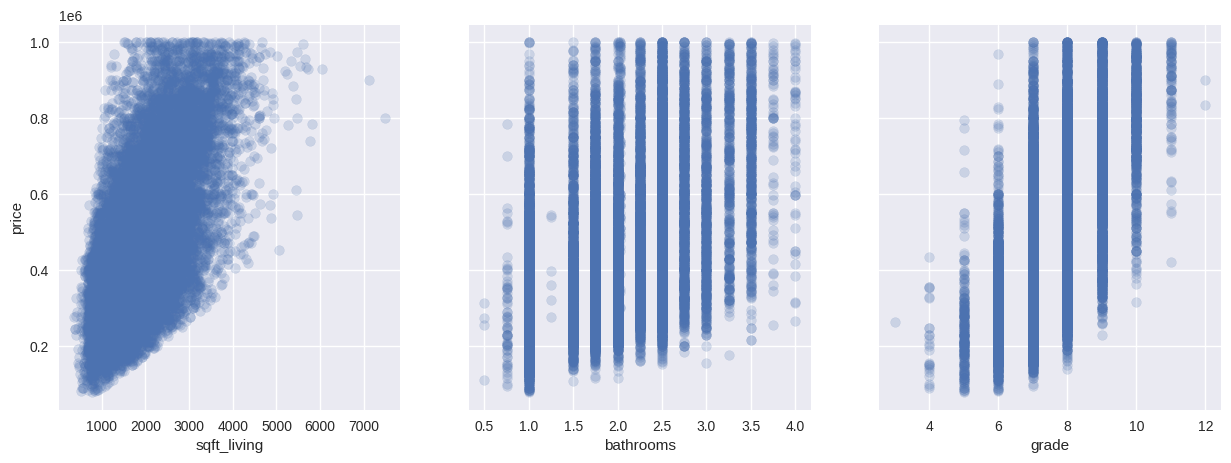

In [80]:
# Plotting Scatter plot
fig, axes = plt.subplots(ncols=3, figsize=(15,5), sharey=True)
axes[0].set_ylabel("price")

for i, col in enumerate(df_subset.drop("price", axis=1).columns):
    ax = axes[i]
    ax.scatter(df_subset[col], df_subset["price"], alpha=0.2)
    ax.set_xlabel(col)

All three features seem to have a linear relationship with price.
The grade feature seem to be almost linearly correlated in comparison to sqft_living and bathrooms.

The outliers in the three features are small to potentially skew our results.

### Step 2: Build a simple Linear Model

In [81]:
# Explore the relationship to find our starting point
df_subset.corr()['price'].to_frame()

,price
sqft_living,0.604018
bathrooms,0.429370
grade,0.617624
price,1.000000


In [82]:
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

# Create a Min-Max scaler
scaler = MinMaxScaler()

# Scale both "grade" and "price"
df_subset["grade_scaled"] = scaler.fit_transform(df_subset[["grade"]])
df_subset["price_scaled"] = scaler.fit_transform(df_subset[["price"]])
df_subset

,sqft_living,bathrooms,grade,price,grade_scaled,price_scaled
1,2570,2.25,7,538000.0,0.444444,0.498915
2,770,1.00,6,180000.0,0.333333,0.110629
3,1960,3.00,7,604000.0,0.444444,0.570499
4,1680,2.00,8,510000.0,0.555556,0.468547
6,1715,2.25,7,257500.0,0.444444,0.194685
...,...,...,...,...,...,...
21591,1310,2.50,8,475000.0,0.555556,0.430586
21592,1530,2.50,8,360000.0,0.555556,0.305857
21593,2310,2.50,8,400000.0,0.555556,0.349241
21594,1020,0.75,7,402101.0,0.444444,0.351520


In [83]:
y = df_subset["price_scaled"]

# grade has the highest correlation of the three features
X_baseline = df_subset[["grade_scaled"]]

In [84]:
baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()
print(baseline_results.summary())

                            OLS Regression Results                            
Dep. Variable:           price_scaled   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                 1.105e+04
Date:                Wed, 25 Oct 2023   Prob (F-statistic):               0.00
Time:                        14:07:40   Log-Likelihood:                 6590.1
No. Observations:               17912   AIC:                        -1.318e+04
Df Residuals:                   17910   BIC:                        -1.316e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.1622      0.006    -28.426   

Our model is statistically significant overall and explains about 38% of the variation in the house prices
Both our intercept and coefficient for grade are statistically significant

Our intercept is a negative value which might imply that if a house had a grade of zero, its price would be negative.

Our coefficient for grade is about 1.2 which suggests that as the grade-scaled value increase by one unit, the price increase by #$ 1.2 